# Multi-Layer Perceptron for classification


##  Implementation of a two layers Multi-Layer Perceptron (MLP) with 1 hidden layer in Python, for a classification problem.

The output of the network is simply the output of several cascaded functions :
- Linear transformations.
- Additive biases.
- Non-linearities.

For this, we will implement:
- the forward propagation
- the computation of the cost/loss
- the backward propagation (to obtain the gradients)
- the update of the parameters

In [1]:
# Loading useful packages and modules
import numpy as np
from sklearn import datasets
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Useful functions

In [2]:
def standardize(X):    
    # center
    X -= np.mean(X, axis=0, keepdims=True)
    # reduce
    X /= (np.std(X, axis=0, keepdims=True) + 1e-16)
    
    return X

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return x * (x > 0)

def dRelu(x):
    y = x
    y[x<=0] = 0
    y[x>0] = 1
    return y

def compute_cost(y_pred, y):
    
    m = y.shape[0]
    
    # Binary cross entropy loss function
    loss =  -(y*np.log(y_pred) + (1 - y)*np.log(1 - y_pred))
    cost = np.sum(loss) / m
    
    return cost

def compute_accuracy(y_pred, y):
    m = y.shape[0]    
    class_y = np.copy(y_pred)
    class_y[class_y>=0.5]=1
    class_y[class_y<0.5]=0
    return np.sum(class_y==y) / m

## Loading dataset

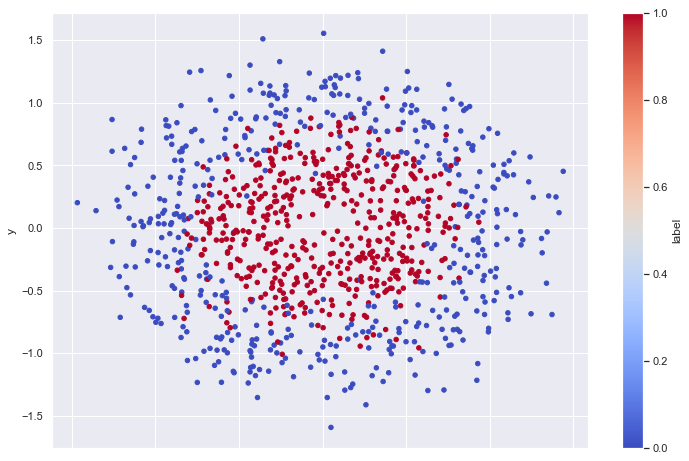

In [3]:
X, y = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)

from pandas import DataFrame
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))

df.plot.scatter(x='x', y='y', c='label', colormap='coolwarm', figsize=(12,8))

In [4]:
print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))
print(set(y))

# Standardize data
X = standardize(X)

# Train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

# input and output dimensions
n_in = X_train.shape[1]
n_out = 1

print("X_train.shape: {}".format(X_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("y_train.shape: {}".format(y_train.shape))
print("y_test.shape: {}".format(y_test.shape))
print("n_in: {} n_out: {}".format(n_in, n_out))

X.shape: (1000, 2)
y.shape: (1000,)
{0, 1}
X_train.shape: (800, 2)
X_test.shape: (200, 2)
y_train.shape: (800, 1)
y_test.shape: (200, 1)
n_in: 2 n_out: 1


## MLP with forward, backward and update methods

In [5]:
class MultiLayerPerceptron:
    """
    Attributes
    ----------
    W1, b1, W2, b2:
        weights and biases to be learnt
    Z1, A1, Z2, A2:
        values of the internal neurons to be used for backpropagation
    dW1, db1, dW2, db2, dZ1, dZ2:
        partial derivatives of the loss w.r.t. parameters
    VdW1, Vdb1, VdW2, Vdb2:
        momentum terms
    """
    
    def __init__(self, n_in, n_hid, n_out):
        self.W1 = np.random.randn(n_in, n_hid) * 0.01
        self.b1 = np.zeros(shape=(1, n_hid))
        self.W2 = np.random.randn(n_hid, n_out) * 0.01
        self.b2 = np.zeros(shape=(1, n_out))        
        # For momentum
        self.VdW1 = np.zeros(shape=(n_in, n_hid)) 
        self.Vdb1 = np.zeros(shape=(1, n_hid))
        self.VdW2 = np.zeros(shape=(n_hid, n_out))
        self.Vdb2 = np.zeros(shape=(1, n_out))
        return

    
    def forward_propagation(self, X):
     
        self.A0 = X

        self.Z1 = np.dot(self.A0, self.W1) + self.b1
        self.A1 = relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2 
        self.A2 = sigmoid(self.Z2)

        hat_y = self.A2
        
        return hat_y


    def backward_propagation(self, X, y):
        
        m = y.shape[0]

        self.dZ2 = self.A2 - y
        self.dW2 = 1/m * np.dot(self.A1.T, self.dZ2)
        self.db2 = 1/m * np.sum(self.dZ2, axis = 0, keepdims = True)
        self.dA1 = np.dot(self.dZ2, self.W2.T)

        self.dZ1 = self.dA1*dRelu(self.Z1)
        self.dW1 = 1/m * np.dot(self.A0.T, self.dZ1)
        self.db1 = 1/m * np.sum(self.dZ1, axis = 0, keepdims = True)

        return

    
    def gradient_descent(self, alpha):

        self.W1 = self.W1 - alpha*self.dW1
        self.b1 = self.b1 - alpha*self.db1
        self.W2 = self.W2 - alpha*self.dW2
        self.b2 = self.b2 - alpha*self.db2
            
        return

    
    def momentum(self, alpha, beta):

        self.VdW1 = beta*self.VdW1 + (1 - beta)*self.dW1
        self.W1 = self.W1 - alpha*self.VdW1

        self.Vdb1 = beta*self.Vdb1 + (1 - beta)*self.db1
        self.b1 = self.b1 - alpha*self.Vdb1

        self.VdW2 = beta*self.VdW2 + (1 - beta)*self.dW2
        self.W2 = self.W2 - alpha*self.VdW2

        self.Vdb2 = beta*self.Vdb2 + (1 - beta)*self.db2
        self.b2 = self.b2- alpha*self.Vdb2
                
        return

## Training

In [6]:
# Number of hidden neurons
n_hid = 10
# Number of epochs
nb_epoch = 5000
# Learning rate
alpha=0.1
# beta parameters for momentum
beta=0.9


# MLP instantiation 
MLP = MultiLayerPerceptron(n_in, n_hid, n_out)

train_cost, train_accuracy, test_cost, test_accuracy = [], [], [], []

for num_epoch in range(0, nb_epoch):
    
    # Forward
    y_pred_train = MLP.forward_propagation(X_train)
    
    # Results on train
    train_cost.append( compute_cost(y_pred_train, y_train) )
    train_accuracy.append( compute_accuracy(y_pred_train, y_train) )
    
    # Backward
    MLP.backward_propagation(X_train, y_train)
    
    # Update
    #MLP.M_gradientDescent(alpha)
    MLP.momentum(alpha, beta)

    # Results on test
    y_pred_test = MLP.forward_propagation(X_test)
    test_cost.append( compute_cost(y_pred_test, y_test) )    
    test_accuracy.append( compute_accuracy(y_pred_test, y_test) )
    
    if (num_epoch % 500)==0: 
        print("epoch: {0:d} (cost: train {1:.2f} test {2:.2f}) (accuracy: train {3:.2f} test {4:.2f})".format(num_epoch, train_cost[-1], test_cost[-1], train_accuracy[-1], test_accuracy[-1]))

epoch: 0 (cost: train 0.69 test 0.69) (accuracy: train 0.51 test 0.47)
epoch: 500 (cost: train 0.66 test 0.67) (accuracy: train 0.67 test 0.64)
epoch: 1000 (cost: train 0.39 test 0.40) (accuracy: train 0.87 test 0.86)
epoch: 1500 (cost: train 0.29 test 0.30) (accuracy: train 0.89 test 0.89)
epoch: 2000 (cost: train 0.27 test 0.27) (accuracy: train 0.91 test 0.89)
epoch: 2500 (cost: train 0.26 test 0.26) (accuracy: train 0.91 test 0.89)
epoch: 3000 (cost: train 0.26 test 0.26) (accuracy: train 0.90 test 0.89)
epoch: 3500 (cost: train 0.26 test 0.26) (accuracy: train 0.90 test 0.89)
epoch: 4000 (cost: train 0.25 test 0.26) (accuracy: train 0.90 test 0.89)
epoch: 4500 (cost: train 0.25 test 0.25) (accuracy: train 0.91 test 0.89)


## Display train/test loss and accuracy

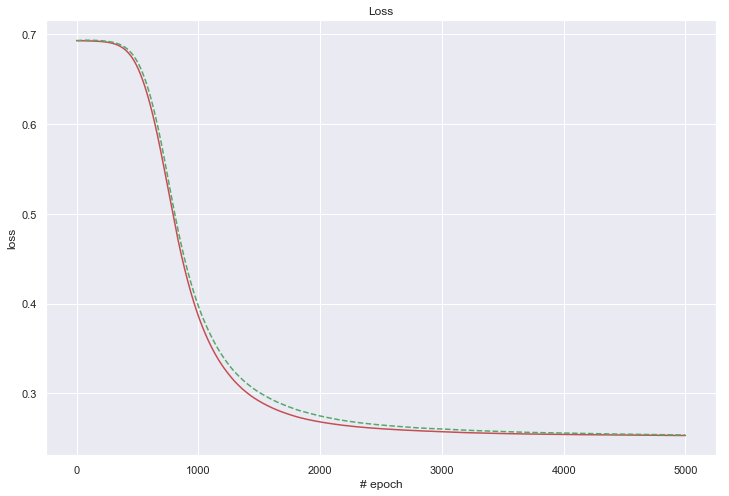

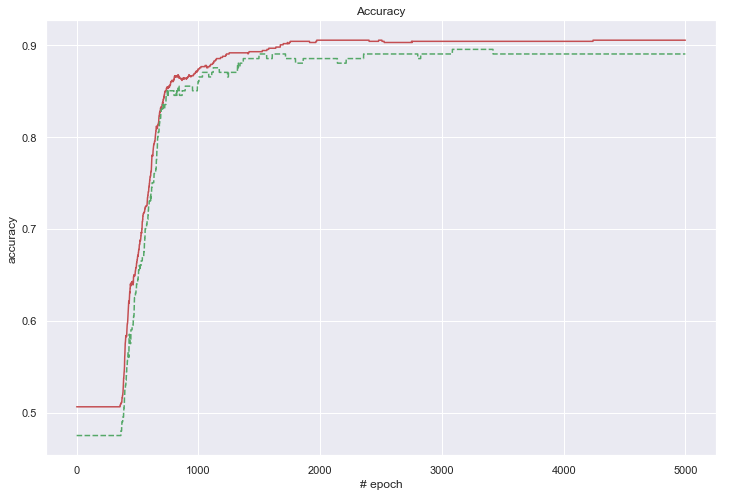

In [9]:
plt.figure(figsize=(12,8))
plt.title('Loss')
plt.plot(train_cost, 'r')
plt.plot(test_cost, 'g--')
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(12,8))
plt.title('Accuracy')
plt.plot(train_accuracy, 'r')
plt.plot(test_accuracy, 'g--')
plt.xlabel('# epoch')
plt.ylabel('accuracy')
plt.show()